In [4]:
%load_ext autoreload
%autoreload 2

# Semantic segmentation of Colon cancer primaries

This is a demonstration of our deep learning pipeline to predict segmentation masks of colon cancer primaries in CT images.

We built our program so that it can easily be run from the command line. In this demonstration we will nevertheless import our functions and create and created an `Args()` class that can be used to specify the settings usually passed by the command line prompt. How to run our program from the command line is shown in the readme.

## Convert NIfTI to Numpy

To train our model and to predict segmentation masks we use axial 2D slices of the CT images, however the original data is provided in 3D NifTI files. We defined the `convert_to_npy()` function to convert 3D NifTI image files to 2D numpy files and save them. In this function we additionally create a JSON file that indexes every single slice. In this index we provide information of whether each slice containes tissue labled as cancer.

In the JSON file we assign each slice to the training or test subsets by calling `create_data_subsets()`. Here, the split ratio and whether to create a split based on individual slices or examples (patients) should be created. For our models we split on individual slices and ensured that the ratio between cancer and non-cancer slices is equal in test and training subset.

Both functions (`convert_to_npy()` and `create_data_subsets()`) are in `dataset.py`.


In [1]:
from dataset import convert_to_npy, create_data_subsets, dir_path
import os

os.makedirs('./data/', exist_ok=True)

In [2]:
class Args():
    datapath = dir_path('./Task10_Colon')
    path = dir_path('./data/')
    split_on = "slices"
    split = 0.1
    
args = Args()

In [18]:
convert_to_npy(args)
create_data_subsets(args)

Successfully created the directory ./data/npy_images/ 
Successfully created the directory ./data/npy_labels/ 
Saved slices of image 001
Saved slices of image 005
Saved slices of image 006
Saved slices of image 007
Saved slices of image 008
Saved slices of image 009
Saved slices of image 011
Saved slices of image 012
Saved slices of image 015
Saved slices of image 022
Saved slices of image 024
Saved slices of image 025
Saved slices of image 026
Saved slices of image 027
Saved slices of image 028
Saved slices of image 029
Saved slices of image 030
Saved slices of image 031
Saved slices of image 032
Saved slices of image 033
Saved slices of image 036
Saved slices of image 038
Saved slices of image 039
Saved slices of image 040
Saved slices of image 041
Saved slices of image 042
Saved slices of image 045
Saved slices of image 046
Saved slices of image 050
Saved slices of image 051
Saved slices of image 053
Saved slices of image 054
Saved slices of image 059
Saved slices of image 061
Saved 

# 2. Dataset and Data Loader

**1) Dataset**

We creates a Custom Dataset; ColonDataset. It uses JSON file which created from *create_data_subsets()* function. *ColonDataset()* class is at **data_loading.py**.  

We can set a sampling method. Otherwise, it uses the original dataset. Three sampling methods are undersample, oversample and only_tumor. Each sampling methods are defined as *get_undersample_files()*, *get_oversample_files()*, *get_only_tumor_files*, and *get_original_dataset()* at **data_loading.py**. 

When the data set is for train, it transforms the data set by resize, random crop, horizontal flipping, vertical flipping, and normalization. Otherwise, it transforms the data set by resize and normalization.

After creating ColonDataset; we split the dataset into train and valid set. This logic is implemented in the *load_datasets()* function. The load_datasets() function is at *train.py*.

**2) Data Loader**

We use *DataLoader* from **pytorch**(torch.utils.data.DataLoader). At *load_dataloader()* function, we creates two data loaders of train and valid set and put both of them in the dictionary as 'train' and 'val'. This dictionary is going to use in the training loop later.

In [1]:
from train import load_datasets, load_dataloader

In [2]:
class Args():
    split_ratio = 0.9
    train_batch = 12
    valid_batch = 12
    trainimages = "./data/npy_images"
    trainlabels = "./data/npy_labels"
    jsonfile = "./data/data_index_subsets.json"
    transform = True
    dataset_type = "only_tumor"
    image_size = 256

args = Args()

In [3]:
train, valid = load_datasets(args)
train_dataloader = load_dataloader(args, train, valid)

# 3. Visualize images from the data loader
CT images from the first batch of train_dataloader.

In [4]:
import matplotlib.pyplot as plt
from utils import gray2rgb, outline

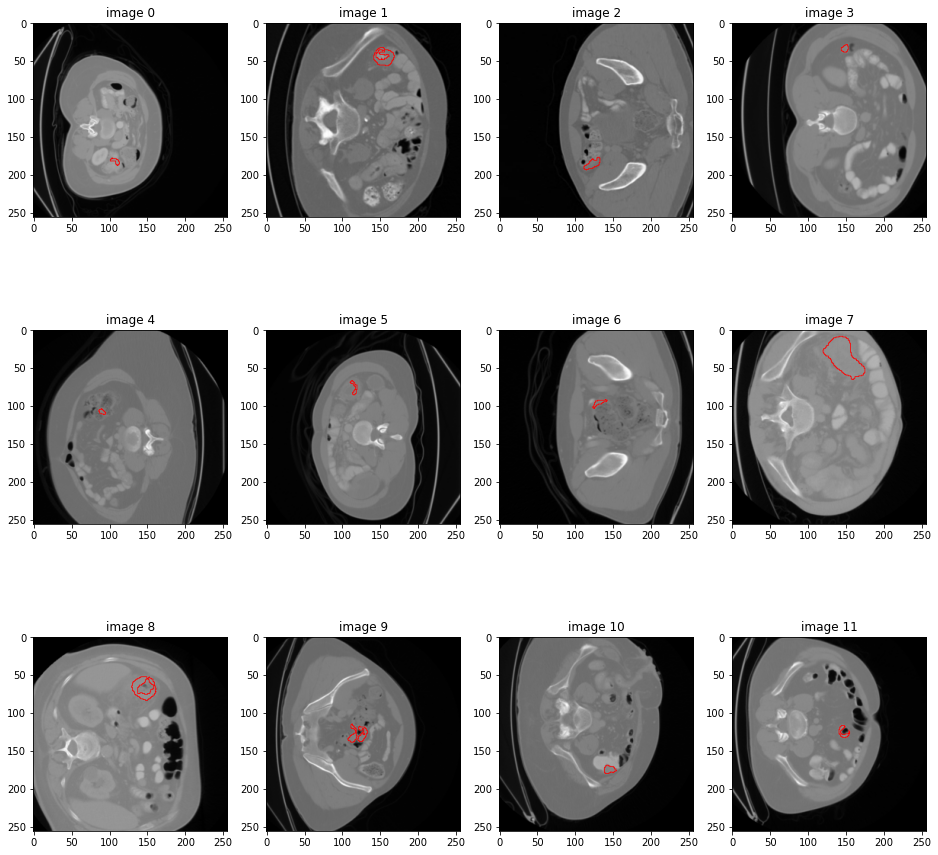

In [5]:
imgs, labels = next(iter(train_dataloader['train']))

def overlay_image(img, y_true):
    image = gray2rgb(img[0])
    image = outline(image, y_true[0], color=[255, 0, 0])
    plt.imshow(image)

columns = 4
rows = 3
fig=plt.figure(figsize=(16, 16))
for i, (img, label) in enumerate(zip(imgs, labels)):
    fig.add_subplot(rows, columns, i+1)
    plt.title('image ' + str(i))
    overlay_image(img, label)

# 4. U-Net Model
We use the U-Net model and the combination of ResNet with the U-Net for image segmentation task. In this demo, we use the U-Net model. Two models are implemented at **architecture.py**.

In [6]:
import torch
from torchsummary import summary
from architecture import UNet

In [7]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0") # set device to GPU if available
model = UNet(n_channel=1, n_class=1).to(device)
summary(model, input_size=(1, args.image_size, args.image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14          [-1, 128,

# 5. Loss function
We use the combination of cross entrophy loss and dice loss to optimize the model. 

The cross entrophy loss is from *pytorch library*. We implements The dice coefficient at **loss.py**. The dice loss is *(1 - dice coefficient)*.

In [8]:
from loss import dice_coef, calc_loss, print_metrics

# 6. Train

We use *SGD (Stochastic gradient descent)* optimizer. The scheduler is *ReduceLROnPlateau*. It allows dynamic learning rate reducing based on some validation measurements. Both of them are from **pytorch** library. 

Early Stopping technique is also implemented at **train.py**. Early stopping is a method that allows you to specify an arbitrarily large number of training epochs and stop training once the model performance stops improving on the validation dataset.

We define *train_method()* function at **train.py**. This function receives optimizer, scheduler, and other parameters and starts training. It saves the best model which shows the lowest validation loss. 

We use Tensorbaord to visualize metrics after finishing training. We also save metrics as a JSON file at '*./save/metrics*' to make us compare the results of each model easily.


In [12]:
from train import train_model
from torch.optim import lr_scheduler, SGD
import json

In [13]:
class Args():
    model_path = "./save/models/"
    metric_path = "./save/metrics/"
    model = "unet"
    dataset_type = "only_tumor"
    lr = 0.001
    epochs = 1
    earlystop = 30
    sched_patience = 10
    image_size = 256
    
args = Args()

In [14]:
# set device
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0") # set device to GPU if available
# specify optimizer function
optimizer = SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr, momentum=0.9)
# initialise learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold_mode='abs', min_lr=1e-8, factor=0.1, patience=args.sched_patience)
# intialize the model
model = UNet(n_channel=1, n_class=1).to(device)
# initialize dictionary to save train informations about the model, dataset, and metrics at the end.
info = {'train': {}}
info_train = info['train']
info_train['model'] = args.model
info_train['dataset'] = args.dataset_type
info_train['image_size'] = args.image_size
info_train['train set size'] = len(train)
info_train['val set size'] = len(valid)
# start train
model, metric_t, metric_v = train_model(model, optimizer, scheduler, device, args.epochs, train_dataloader, info_train, args)
# save info as a json file at "./save/metrics"
with open(f"{args.metric_path}best_metric_{args.model}_{args.dataset_type}_{args.epochs}.json", "w") as json_file:
    json.dump(info, json_file, indent=4)

Epoch 1/1
----------
LR 0.001
train: bce: 0.713416, dice_loss: 0.985676, loss: 1.699091
val: bce: 0.713446, dice_loss: 0.985147, loss: 1.698592
Validation loss decreased (inf --> 1.698592).  Saving best model ...
0m 38s
Best val loss: 1.698592


In [15]:
# to see visualizations of loss change
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.3.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


# 7. Test
We define *load_datasets()* and *load_dataloader()* functions at **test.py** to load the test set which is splitted at the *step 1: Convert NIfTI to Numpy*. 

Similar to train_model() at the *step 7: Train*, we also define *test_model()* at **test.py** which starts evaluating the model and prints the evaluation metrics at the end. The evaluation metrics are saved at the JSON file. We create *metrics_summary()* function at **utils.py**. We can get statistics from the evaluation metrics which are saved at the JSON file.

In this demo, we are going to load the best model which is already trained using oversample sampling method with U-Net model.

In [1]:
from test import load_datasets, load_dataloader, test_model
import os
import json
import torch
from architecture import UNet

In [2]:
class Args():
    testimages = "./data/npy_images"
    testlabels = "./data/npy_labels"
    jsonfile = "./data/data_index_subsets.json"
    image_size = 256
    transform = True
    model_path = "./save/models/"
    metric_path = "./save/metrics/"
    model = "unet"
    metric_dataset_type = "oversample"
    epochs = 200
    pred_save = True
    
args = Args()

In [3]:
# initialize device and model
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0") # set device to GPU if available
model = UNet(n_channel=1, n_class=1).to(device)

# load test data
test = load_datasets(args)
test_dataloader = load_dataloader(test)

# initialize a dictionary to save metrics for evaluation
info_test = {'test set size':0, 'average_dice_score':0, \
             'number of cancer case': 0, 'average_cancer_dice_score':0, \
             'number of non-cancer case': 0, 'average_non_cancer_dice_score':0, \
             'gt_c_pd_c_overlap':0, 'gt_c_pd_c_no_overlap':0, 'gt_c_pd_no_c':0, \
             'gt_n_pd_n': 0, 'gt_n_pd_c':0, 'dice_score_each_slice':[]}
info_test['test set size'] = len(test_dataloader['test'])

# start test
result = test_model(model, device, test_dataloader, args.pred_save, info_test, args)

# save the result from the evalutaion
with open(f"{args.metric_path}best_metric_{args.model}_{args.metric_dataset_type}_{args.epochs}.json", 'ab+') as f:
    f.seek(0,2)                                #Go to the end of file    
    if f.tell() == 0 :                         #Check if file is empty
        f.write(json.dumps(info_test, indent=4).encode())  #If empty, write an array
    else:  
        f.seek(-1,2)           
        f.truncate() 
        f.write(', "test": '.encode()) 
        f.write(json.dumps(info_test, indent=4).encode())    #Dump the dictionary
        f.write('}'.encode())  

----------
The Evaluation Starts ...
----------
The total samples: 1348
The average dice score is 0.9651367664337158.
The number of cancer samples: 127
The average dice score of the slices which have cancer is 0.6534808874130249.
The number of correct cases when the prediction predicts some poriton of the cancer: 103
The number of incorrect cases when the prediction predicts some poriton of the cancer: 0
The number of cases when the prediction predicts no cancer but it has cancer: 24
The number of non-cancer samples: 1221
The average dice score of the slices which have non-cancer is 0.9975532293319702.
The number of cases when the prediction predicts no cancer when it has no cancer: 1218
The number of cases when the prediction predicts cancer when it has no cancer: 3
0m 30s


# 8. Visualize predictions from the trained model
It's not tested yet


In [35]:
import matplotlib.pyplot as plt
import numpy as np
from utils import gray2rgb, outline, overlay_plot
import random

In [36]:
cancer_index = []
no_cancer_index = []
for i, j in result.items():
    if j['cancer_gt'] and j['cancer_pd']:
        cancer_index.append(i)
    else:
        no_cancer_index.append(i)
print(cancer_index)

[12, 13, 14, 45, 51, 52, 78, 79, 80, 89, 90, 91, 106, 116, 132, 133, 144, 145, 186, 187, 211, 231, 268, 269, 270, 271, 272, 290, 314, 315, 331, 332, 348, 362, 374, 403, 451, 464, 478, 489, 490, 505, 536, 537, 545, 570, 574, 629, 650, 660, 671, 680, 701, 702, 720, 728, 761, 762, 763, 805, 806, 807, 834, 835, 846, 847, 868, 869, 878, 885, 896, 897, 898, 912, 926, 982, 983, 984, 1028, 1029, 1044, 1064, 1065, 1066, 1117, 1123, 1132, 1144, 1160, 1174, 1188, 1198, 1210, 1211, 1212, 1258, 1259, 1260, 1291, 1292, 1300, 1337, 1338]


In [37]:
cancer_index = random.sample(cancer_index, 5)
no_index = random.sample(no_cancer_index, 5)
index = np.concatenate((cancer_index, no_index))
index

array([ 268,  403,  912,  926,  878,  930, 1347,  415,  488, 1254])

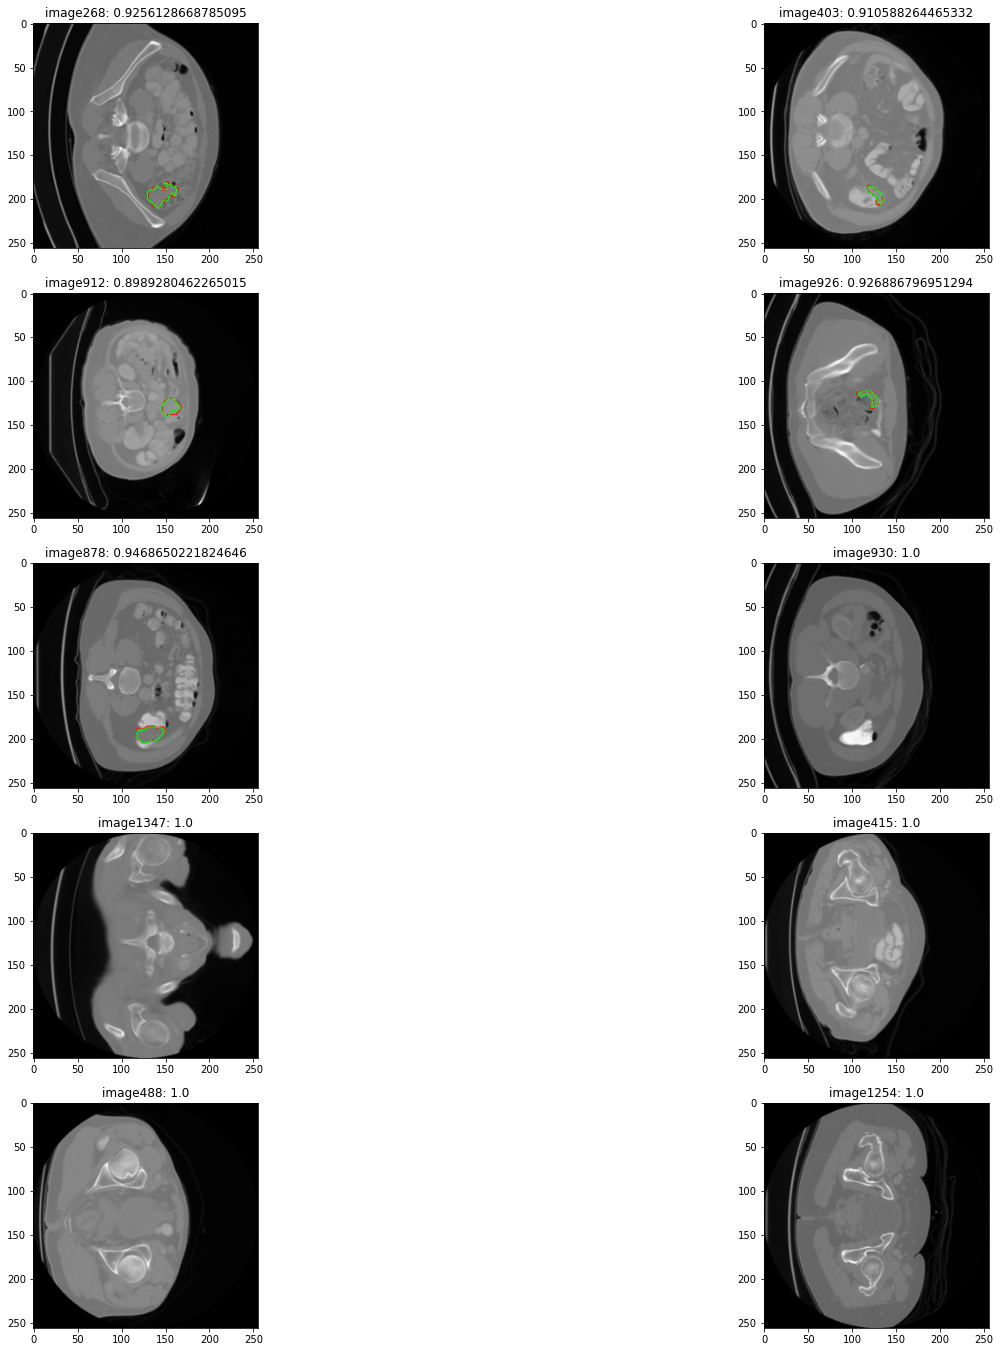

In [40]:
columns = 2
rows = 5
fig=plt.figure(figsize=(24, 24))
for pos, i in enumerate(index):
    fig.add_subplot(rows, columns, pos+1)
    plt.title("image" + str(i) + ": " + str(result[i]['dice']))
    image = overlay_plot(result[i]['img'], result[i]['label'], result[i]['pred'], i, False)
    plt.imshow(image)

In [44]:
from utils import metrics_summary

In [45]:
metrics_summary("./save/metrics")

Model        Dataset         avg_dice c_dice n_dice precision recall overlap FPR   FNR  


NameError: name 'metrics_path' is not defined